# Predicting sentiment from product reviews

### Due: Wednesday, April 29, at 11:59 pm on Gradescope

The goal of this first notebook is to explore logistic regression and feature engineering with sklearn.

In this notebook you will use product review data from Amazon.com to predict whether the sentiments about a product (from its reviews) are positive or negative.

* Use Pandas Dataframes to do feature engineering
* Train a logistic regression model to predict the sentiment of product reviews.
* Inspect the weights (coefficients) of a trained logistic regression model.
* Make a prediction (both class and probability) of sentiment for a new product review.
* Given a classifier, create a confusion matrix
* Compare multiple logistic regression models.

Copyright ©2020 Emily Fox, Hunter Schafer, Valentina Staneva.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Spring Quarter 2020 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.


In [0]:
!pip install -q seaborn==0.9.0
!pip install -q scikit-learn==0.20.3

In [0]:
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import math
import string
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import json
import gzip
from urllib.request import urlopen

# Data preparation

We will use a dataset consisting of food product reviews on Amazon.com [source](http://jmcauley.ucsd.edu/data/amazon/).

In [77]:
!wget https://raw.githubusercontent.com/valentina-s/cse-stat-416-sp20/master/data/food_products.csv

--2020-04-29 09:53:11--  https://raw.githubusercontent.com/valentina-s/cse-stat-416-sp20/master/data/food_products.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1319440 (1.3M) [text/plain]
Saving to: ‘food_products.csv.1’

food_products.csv.1 100%[===================>]   1.26M  --.-KB/s    in 0.04s   

2020-04-29 09:53:11 (29.1 MB/s) - ‘food_products.csv.1’ saved [1319440/1319440]



In [78]:
products = pd.read_csv('food_products.csv')
print(len(products))
products.iloc[1]['review']

2500


'I found these in a Mitsuwa Marketplace in Illinois.I actually expected them to taste better than the did.  they were okay but seem smaller than standard kit kats and the taste was a tad mild compared to other green tea candies I have tried.But still, they were pleasant enough and nice for a change.'

## Extract sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [79]:
products = products[products['rating'] != 3]
len(products)

1729

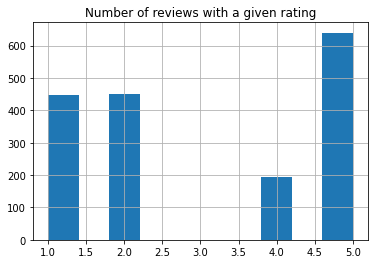

In [80]:
plt.title('Number of reviews with a given rating')
products['rating'].hist()

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [81]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
products[0:20]

,Unnamed: 0,summary,review,rating,sentiment
2,9,Not a fan,"I love green tea, I love Kit Kats, but the two...",1.0,-1
4,20,Thai curry is the way to go to add spice to an...,So many flavors. I can't begin to tell you how...,5.0,1
5,28,Delicious,I have tried all the curris from Mae Ploy (exc...,5.0,1
7,32,Not natural/organic at all,This product is no where near natural / organi...,1.0,-1
9,46,They work well enough.,"There's a vague taste of apple cinnamon, but m...",4.0,1
11,49,Lessens the effects of an asthma attack,If my wife drinks a cup of this tea when she f...,5.0,1
13,54,Dark Chocolate Toffee Nut - fantastic flavor! ...,I really enjoy PowerBar ProteinPlus bars - but...,5.0,1
15,63,Nostalgia,"I was born in the 80's, and this was brought i...",5.0,1
16,65,great,my niece teaches underprivileged kids in flori...,5.0,1
17,75,Not soft at all. Basically same as cheap licor...,"Licorice is my favorite candy, and it promotes...",1.0,-1


Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

## Build the word count vector for each review

Let us explore a specific example of a food product.

In [82]:
products.iloc[21]

Unnamed: 0                                                  162
summary                                                Not good
review        unsure if I just got a bad batch or what...the...
rating                                                        1
sentiment                                                    -1
Name: 37, dtype: object

Now, we will perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Transform the reviews into word-counts.

**Aside**. In this assignment, we remove all punctuations for the sake of simplicity. A smarter approach to punctuations would preserve phrases such as "I'd", "would've", "hadn't" and so forth. See [this page](ftp://ftp.cis.upenn.edu/pub/treebank/public_html/tokenization.html) for an example of smart handling of punctuations.

In [0]:
def remove_punctuation(text):
    if type(text) != str:
        return ''
    return text.translate(str.maketrans('', '', string.punctuation))

products['review_clean'] = products['review'].apply(remove_punctuation)

Now, let us explore what the sample example above looks like after these 2 transformations.

In [0]:
word_count = []

for i in range(0,len(products)):
    word_count_dict = {}
    review_clean = products['review_clean'].iloc[i]
    review_clean = review_clean.split(' ')
    for word in review_clean:
        if word in word_count_dict.keys():
            word_count_dict[word] += 1
        else:
            word_count_dict[word] = 1
    word_count.append(word_count_dict)

products['word_count'] = word_count

In [0]:
# Create a DictVectorizer and create vectors for these dictionaries
dictVectorizer = DictVectorizer()
features_Frame = dictVectorizer.fit_transform(products['word_count'])

In [86]:
#  Create a new DataFrame that has all these features as columns plus the sentiment label!
product_data = pd.DataFrame(features_Frame.toarray())
product_data['sentiment'] = list(products['sentiment'])
product_data['review_clean'] = list(products['review_clean'])  # to display later
product_data['summary'] = list(products['summary'])  # to display later
product_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,13715,13716,13717,13718,13719,13720,13721,13722,13723,13724,13725,13726,13727,13728,13729,13730,13731,13732,13733,13734,13735,13736,13737,13738,13739,13740,13741,13742,13743,13744,13745,13746,13747,13748,13749,13750,13751,sentiment,review_clean,summary
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,I love green tea I love Kit Kats but the two d...,Not a fan
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,So many flavors I cant begin to tell you how m...,Thai curry is the way to go to add spice to an...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,I have tried all the curris from Mae Ploy excl...,Delicious
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,This product is no where near natural organic...,Not natural/organic at all
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Theres a vague taste of apple cinnamon but mos...,They work well enough.


## Split data into training, validation and test sets.

Let's perform a train/validation/test split with 80% of the data in the training set, 10% of the data in the validation set, 10% test. We use `random_state = 1` so that everyone gets the same result.

In [0]:
train_data, test_data = train_test_split(product_data, test_size = 0.2, random_state = 1)
validation_data, test_data = train_test_split(test_data, test_size = 0.5, random_state = 1)

## Baseline: Majority class prediction

It is quite common to use the **majority class classifier** as the a baseline (or reference) model for comparison with your classifier model. The majority classifier model predicts the majority class for all data points. Given a classification problem with 2 classes, the majority class classifier has at least 50% accuracy.

**Question 1:** What is the accuracy of the majority class classifer on the **validation_data**

**Hint:** pandas allows you to take the sum of a boolean series - true values are equal to 1, false values are equal 0.

In [183]:
# TODO

## dummy model method
# from sklearn.dummy import DummyClassifier
# from sklearn.metrics import accuracy_score
# dummy_clf = DummyClassifier(strategy="most_frequent")
# dummy_clf.fit(train_data[features], train_data['sentiment'])
# print(accuracy_score(train_data['sentiment'],dummy_clf.predict(train_data[features])))
# print(accuracy_score(validation_data['sentiment'],dummy_clf.predict(validation_data[features])))

# manual calculation
majority = 1 if sum(train_data['sentiment'])>0 else -1
print("majority of train \t=",majority)
print("accuracy on train \t=",sum(train_data['sentiment']==majority)/len(train_data))
print("accuracy on validation \t=",sum(validation_data['sentiment']==majority)/len(validation_data))

0.5126536514822849
0.5144508670520231
majority of train 	= -1
accuracy on train 	= 0.5126536514822849
accuracy on validation 	= 0.5144508670520231


# Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data. This model will use the column **word_count** as a feature and the column **sentiment** as the target. We will set **no regularization penalty** and set `random_state = 1` to get the same answer as everyone else. sklearn.LogisticRegression (documentation here) uses a value named c for the regularization hyper-parameter where  𝑐=1𝜆 . This means a really large value of c corresponds to a very small  𝜆 .

**Note:** This line may take a few minutes.

In [89]:
features = list(train_data.columns)
features.remove('sentiment')
features.remove('review_clean')
features.remove('summary')

#Note: C = 1/Lambda. Setting C to a really high value is the same as setting lambda = 0
sentiment_model = LogisticRegression(penalty='l2', random_state = 1, C = 1e23)
sentiment_model.fit(train_data[features], train_data['sentiment'])

LogisticRegression(C=1e+23, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Let's look at some of the coefficients and the corresponding words. The weights are stored in a `coef_` object: 

In [0]:
weights = sentiment_model.coef_[0] 

The words are stored in the Vectorizer object:


In [0]:
feature_names = dictVectorizer.get_feature_names()




**Question 2:** Find the word with the lowest weight and enter the number in Gradescope. Explore some of the words with high and low weights: do they make sense.

In [92]:
# TODO
max_i = np.argmax(weights)
min_i = np.argmin(weights)
print("word with max weight:", feature_names[max_i], "\tweight =", weights[max_i])
print("word with min weight:", feature_names[min_i], "\tweight =", weights[min_i])

word with max weight: Does 	weight = 5.384696063800742
word with min weight: Not 	weight = -4.431331345347807


## Making predictions with logistic regression

Now that a model is trained, we can make predictions on the **validation data**. In this section, we will explore this in the context of 3 examples in the validation dataset.  We refer to this set of 3 examples as the **sample_data**.

In [93]:
sample_data = validation_data[10:13]
sample_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,13715,13716,13717,13718,13719,13720,13721,13722,13723,13724,13725,13726,13727,13728,13729,13730,13731,13732,13733,13734,13735,13736,13737,13738,13739,13740,13741,13742,13743,13744,13745,13746,13747,13748,13749,13750,13751,sentiment,review_clean,summary
60,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,When I was incarcerated in a Mexican prison th...,taste is awful
1557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,a good buy for walnut piecesA known brand name...,a good buy fo walnut pieces...
733,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Theres a lot of talk about echinacea being a l...,"There Ought To Be No ""U"" (or ""K"") in Yogi"


### Predicting sentiment


In [94]:
print ("Probability predictions on the sample data:")
print('Negative Sentiment  Positive Sentiment')
print(sentiment_model.predict_proba(sample_data[features]))

Probability predictions on the sample data:
Negative Sentiment  Positive Sentiment
[[9.99979475e-01 2.05250416e-05]
 [1.03995426e-04 9.99896005e-01]
 [4.22307054e-07 9.99999578e-01]]


In [95]:
print(sentiment_model.predict(sample_data[features]))

[-1  1  1]


# Find the most positive (and negative) review

We now turn to examining the full **validation_data** dataset <span style="color:red">(not sample_data)</span>, , and use `sklearn` to form predictions on all of the data points for faster performance.

Using the `sentiment_model`, find review/reviews in the **validation_data** with the **highest probability** of being classified as a **positive review**. We refer to this as the "most positive review." Record the **first** occurrence of such a review on Gradescope. 

Hint: Once you know the index of the most positive/negative reviews, use the .iloc[] accessor on the DataFrame to get that row and find its name.

In [157]:
# TODO
probabilities = sentiment_model.predict_proba(validation_data[features])
max_neg, max_pos = np.argmax(probabilities,axis=0)
print("most pos index =",max_pos," \tprob =",probabilities[max_pos,1])
print("most neg index =",max_neg," \tprob =",probabilities[max_neg,0])
print(validation_data.iloc[max_pos]['review_clean'])
print(validation_data.iloc[max_neg]['review_clean'])

most pos index = 48  	prob = 0.9999999999999953
most neg index = 153  	prob = 1.0
I give the product 5 stars  These peanuts have always been my favorite  The price with subscribe and save is terrific especially when there is a coupon available  My peanuts came fresh and well packages  My biggest issue with these is they are so good that I can not eat just 1 serving or 2 for that matter  So 1 star for my willpower and 5 stars for the peanuts
I give this product two stars because there are no artificial ingredients and it is 75 organic That is all it has going for itIm trying to go all natural and organic with all my purchases I saw this for about 5 for the five pack and since the price was comparable to the Velveeta version which is far from all natural I bought itStirring the cheese sauce into the leftover water from cooking the macaroni took a few minutes I did not time it but it was more than two minutes My son would not eat it I made myself a package It tastes kind of like macaroni 

**Question 3**: Using the sentiment model with validation_data, which product has the most positive review? 
* Kellogg's Frosted Flakes
* sugar cubes
* Zico coconut water
* canned soup
* Pecan Shortbread

**Question 4**: Using the sentiment model with validation_data, which product has the most negative review?
* Kellogg's Frosted Flakes
* peppermint tea
* Zico coconut water
* Newmann Organic Product
* Pecan Shortbread



# Create a confusion matrix

A common tool in dealing with classification is the confusion matrix.

We've created a function that will plot a confusion matrix for you given a set of inputs which are the values that should appear within each cell.
Recall that there are four values associated with a confusion matrix: true positive, true negative, false positive, and false negative which we will abberviate as TP, TN, FP, and FN, respecitvely. 

In [0]:
def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values 
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg'])


Write code below that uses the `plot_confusion_matrix` function to show the number of true positive, true negative, false positive, and false negative predictions made by your classifier. You might find it useful to use named parameters here (i.e. you can call `plot_confusion_matrix(tp=X, fp=Y, fn=A, tn=B)` instead of having to get the order of tha parameters correct)

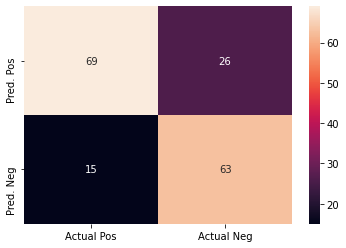

In [175]:
# TODO
tp = fp = fn = tn = 0
predictions = sentiment_model.predict(validation_data[features])
labels = list(validation_data['sentiment'])
for i in range(0, len(validation_data)):
    if (predictions[i]>0):
        if (predictions[i]==labels[i]):
            tp+=1
        else: 
            fp+=1
    else:
        if (predictions[i]==labels[i]):
            tn+=1
        else: 
            fn+=1
plot_confusion_matrix(tp, fp, fn, tn)

**Question 5:** Using the sentiment_model on the validation_data, how many products are classified as having negative sentiment that should be classified as having a positive sentiment?

# Calculating Accuracy

Now that we have succesfully trained a model, let's compare the accuracy of the sentiment_model to that of the baseline classifier.

Below, calculate the accuracy of each model using sklearn's [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function.

In [191]:
# TODO
print("baseline accuracy on test =",accuracy_score(test_data['sentiment'], [majority]*len(test_data)))
print("sentiment_model accuracy on test =",accuracy_score(test_data['sentiment'], sentiment_model.predict(test_data[features])))

baseline accuracy on test = 0.5664739884393064
sentiment_model accuracy on test = 0.8092485549132948


**Question 6:** Based on their respect accuracies, which model would we expect to perform better on unseen data?

### Logistic Regression with L2 regularization

One of the challenges of creating features from each word is that there are many more features than observations. It is easy to overfit. We will explore the effect of the regularization on this problem.

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our simple logistic regression implementation.

**TASK:** Train a model with the `feature_names` as features for each of the `l2_penalties` to predict the target `sentiment`. Add a column to `table` with the respective `column_name`, and save the coefficients with the model.

You should end up with an DataFrame with column names as 'coefficients \[L2=1\]', ... 'coefficients \[L2=1e5\]', and a row for each word in `feature_names`.

Use `random_state = 1` to get the same results.

**Hint**: You might want to use numpy.transpose() at the end.

**Note**: Set `fit_intercept = False`.

<span style="color:red">Note: when constructing the LogisticRegression(...) model, the parameter `C` is the **inverse** of the L2 penalty (1 / L2_penalty). </span>

In [204]:
# TODO Fill in the loop
l2_penalties = [1, 4, 10, 1e2, 1e3, 1e5]
l2_penalty_names = ['coefficients [L2=1]', 'coefficients [L2=4]', 'coefficients [L2=10]', 
                    'coefficients [L2=1e2]', 'coefficients [L2=1e3]', 'coefficients [L2=1e5]']

# Add the coefficients to this table for each model
table = pd.DataFrame(columns = ['word'] + l2_penalty_names)
table['word'] = feature_names

for l2_penalty, column_name in zip(l2_penalties, l2_penalty_names):
    # TODO: Train the model and save the coefficients
    model = LogisticRegression(penalty='l2', random_state = 1, C = 1/l2_penalty, fit_intercept = False)
    model.fit(train_data[features], train_data['sentiment'])
    table[column_name] = model.coef_[0]
table.head()

,word,coefficients [L2=1],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,,0.039932,0.030597,0.027102,0.026090,0.019582,-0.000500
1,0,0.137752,0.108966,0.087793,0.029444,0.003514,0.000027
2,0000,0.045107,0.023884,0.013162,0.002197,0.000387,0.000005
3,002,-0.001946,-0.001643,-0.001363,-0.000672,-0.000173,-0.000004
4,004,-0.001946,-0.001643,-0.001363,-0.000672,-0.000173,-0.000004


## Look at the Coefficients

We'll now look at the **coefficients** for the model that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

Using **the coefficients trained with L2 penalty 1**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.

**Question 7:** Which of the following appears in neither positive_words nor negative_words?

* best
* not
* tastes
* bad
* was


**Hint:** You can use the `.nlargest()`and `.nsmallest()` method on an DataFrame to find the top k rows sorted according to the value of a specified column.

In [212]:
# TODO
positive_words = table.nlargest(5, 'coefficients [L2=1]')['word']
negative_words = table.nsmallest(5, 'coefficients [L2=1]')['word']
print(positive_words)
print(negative_words)

7620        great
6538         easy
1693        Great
4598         best
6056    delicious
Name: word, dtype: object
2501        Not
4673      bland
12961     tried
9564        not
4657     bitter
Name: word, dtype: object


Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

In [0]:
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, list(table_positive_words.iloc[i]),
                 '-', label=positive_words.iloc[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, list(table_negative_words.iloc[i]),
                 '-', label=negative_words.iloc[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -3, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

Run the following cell to generate the plot. Use the plot to answer the following quiz question.

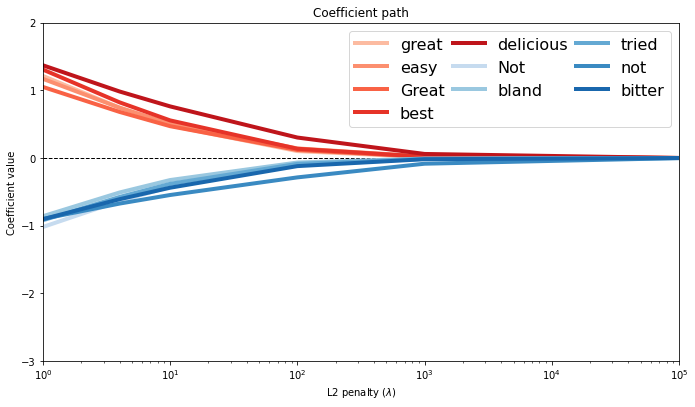

In [213]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[1, 4, 10, 1e2, 1e3, 1e5])

Calculate how the accuracy on the validation data changes with the increase of the l2 penalty. 

In [218]:
# TODO
for l2_penalty in l2_penalties:
    # TODO: Train the model and save the coefficients
    model = LogisticRegression(penalty='l2', random_state = 1, C = 1/l2_penalty, fit_intercept = False)
    model.fit(train_data[features], train_data['sentiment'])
    print("l2_penalty =", l2_penalty, "\taccuracy on validation =", accuracy_score(validation_data['sentiment'], model.predict(validation_data[features])))

l2_penalty = 1 	accuracy on validation = 0.7630057803468208
l2_penalty = 4 	accuracy on validation = 0.7687861271676301
l2_penalty = 10 	accuracy on validation = 0.7687861271676301
l2_penalty = 100.0 	accuracy on validation = 0.7687861271676301
l2_penalty = 1000.0 	accuracy on validation = 0.7109826589595376
l2_penalty = 100000.0 	accuracy on validation = 0.5317919075144508


**Question 9**: What is the effect on the accuracy on unseen data for the ridge regression prediction as you make lambda *very large*?
* increases
* decreases 

Do you have an explanation of why this happens. (Optional) Compare the results with l1 LASSO regression.